# 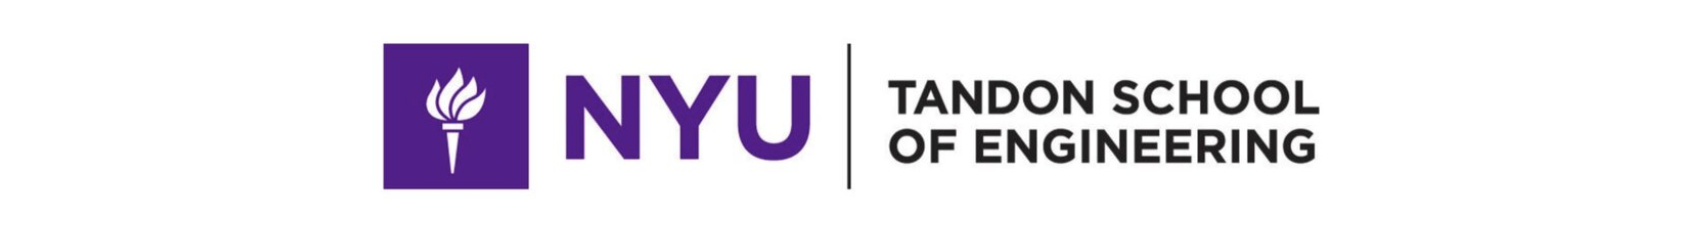

# Reducing Customer Churn in Retail with Personalized Incentives

### Big Data (CSGY-6513-C) | Fall 2024
##### Team Members: 
* Abhishek Agrawal aa9360 
* Shubham Naik svn9724 
* Vaibhav Rouduri vr2470

In [ ]:
# Installing Libraries
pip3 install pandas
pip3 install numpy
pip3 install matplotlib
pip3 install seaborn
pip3 install plotly
pip3 install scikit-learn
pip3 install xgboost

In [15]:
# Importing Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

# Exploratory Data Analysis
The dataset consist of eight tables in separate .csv files, we will go through six of them which we will use in this notebook. The dataset covers a two year span purchase transactions of 2500 households. Also demographics information of households, campaign and coupon redemption informations are available. In the modeling phase we will join these tables to make our final dataset.

* Campaign Descriptions (campaigndesc.csv)
* Campaigns (campaign_table.csv)
* Coupons (coupon.csv)
* Coupon Redemptions (coupon_redempt.csv)
* Transactions (transaction_data.csv)
* Demographics (hh_demographic.csv)

In [9]:
transactions = pd.read_csv('transaction_data.csv')
demographics = pd.read_csv('hh_demographic.csv')
products = pd.read_csv('product.csv')

In [10]:
transaction_trends = transactions.groupby(['household_key', 'BASKET_ID', 'STORE_ID', 'DAY', 'WEEK_NO']).agg({
                            'QUANTITY': 'sum', 'SALES_VALUE': 'sum', 'RETAIL_DISC': 'sum', 'COUPON_DISC': 'sum', 'COUPON_MATCH_DISC': 'sum'}).reset_index()

In [46]:
# Recency: Days since the last purchase.
# Frequency: Number of transactions over a defined period (e.g., past 30/60/90 days).
# Monetary Value: Total spending over a defined period.
# Average Basket Size: Average number of items per basket.
# Discount Utilization: Average discount per transaction.

latest_week = int(max(transaction_trends['WEEK_NO'].unique()))
def churn_probability(x):
  if x < 4:
    return round(x/4, 2)
  return 1.00

features = transaction_trends.groupby(['household_key']).agg(
  latest_week_no=('WEEK_NO', 'max'),
  total_weeks=('WEEK_NO', 'nunique'),
  total_quantity=('QUANTITY', 'sum'),
  count_retail_disc=('RETAIL_DISC', lambda x: (x != 0.0).sum()),
  count_coupon_disc=('COUPON_DISC', lambda x: (x != 0.0).sum()),
  count_coupon_match_disc=('COUPON_MATCH_DISC', lambda x: (x != 0.0).sum()),
  total_sales_value=('SALES_VALUE', 'sum'),
  total_retail_disc=('RETAIL_DISC', 'sum'),
  total_coupon_disc=('COUPON_DISC', 'sum'),
  total_coupon_match_disc=('COUPON_MATCH_DISC', 'sum'),
  basket_count=('BASKET_ID', 'count')
).reset_index().merge(demographics, on='household_key', how='left')

churn_features = features[['household_key']].copy()
churn_features['frequency'] = features['basket_count'] / features['total_weeks']
churn_features['monetary_value'] = features['total_sales_value'] / features['total_weeks']
churn_features['average_basket_size'] = features['total_quantity'] / features['basket_count']
churn_features['discount_utilization'] = (features['total_retail_disc'] + features['total_coupon_disc'] + features['total_coupon_match_disc']) / features['basket_count']
churn_features['discount_count'] = (features['count_retail_disc'] + features['count_coupon_disc'] + features['count_coupon_match_disc']) / features['basket_count']

churn_features['recency'] = latest_week - features['latest_week_no']
churn_features['churn_probability'] = churn_features['recency'].apply(lambda x: churn_probability(x))
churn_features['is_churn'] = churn_features['churn_probability'] > 0.5

churn_features

,household_key,frequency,monetary_value,average_basket_size,discount_utilization,discount_count,recency,churn_probability,is_churn
0,1,1.264706,63.678824,23.220930,-9.345930,1.453488,0,0.00,False
1,2,1.285714,55.838286,18.533333,-7.644222,1.044444,6,1.00,True
2,3,1.270270,71.708378,181.702128,-16.088298,1.191489,1,0.25,False
3,4,1.153846,46.158077,12.733333,-3.938333,0.966667,12,1.00,True
4,5,1.481481,28.854074,6.125000,-2.958250,0.750000,1,0.25,False
...,...,...,...,...,...,...,...,...,...
2495,2496,1.312500,90.409583,2068.317460,-18.715714,1.507937,4,1.00,True
2496,2497,2.569767,82.697442,277.085973,-6.147602,0.895928,1,0.25,False
2497,2498,2.567164,38.829851,182.203488,-1.624419,0.720930,0,0.00,False
2498,2499,1.666667,62.853148,1593.877778,-5.578889,0.844444,0,0.00,False


In [47]:
X, y = churn_features.drop(columns=['is_churn', 'churn_probability', 'recency', 'household_key']), churn_features['is_churn']
Xtr, Xts, ytr, yts = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

In [48]:
from sklearn.linear_model import LogisticRegression

logistic_model = LogisticRegression(random_state=42, max_iter=1000)
logistic_model.fit(Xtr, ytr)
logistic_y_pred = logistic_model.predict(Xts)
logistic_acc = accuracy_score(yts, logistic_y_pred)

print(f"Logistic Regression Accuracy: {logistic_acc}")

Logistic Regression Accuracy: 0.7306666666666667


In [49]:
from sklearn.neural_network import MLPClassifier

mlp_model = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
mlp_model.fit(Xtr, ytr)
mlp_y_pred = mlp_model.predict(Xts)
mlp_acc = accuracy_score(yts, mlp_y_pred)

print(f"MLP Neural Network Accuracy: {mlp_acc}")

MLP Neural Network Accuracy: 0.732


In [50]:
from sklearn.ensemble import RandomForestClassifier

n_splits = 6
kf = KFold(n_splits=n_splits, random_state=None, shuffle=False)
models = {}
for fold_index, (train_index, test_index) in enumerate(kf.split(X)):
  X_train, X_val = X.iloc[train_index], X.iloc[test_index]
  y_train, y_val = y.iloc[train_index], y.iloc[test_index]
  model = RandomForestClassifier(n_estimators=200, random_state=42)
  model.fit(X_train, y_train)
  y_pred = model.predict(X_val)
  models[accuracy_score(y_val, y_pred)] = model

accuracy = max(list(models.keys())) 
model = models[accuracy]
print(f"Accuracy: {accuracy}")

Accuracy: 0.7721822541966427


In [51]:
y_pred = model.predict(Xts)
print(accuracy_score(yts, y_pred))

0.9613333333333334


In [52]:
print("Best Accuracy:", model.feature_importances_)

Best Accuracy: [0.24244629 0.20489116 0.1955648  0.1816935  0.17540424]


In [53]:
import joblib
joblib.dump(model, 'random_forest_model.pkl')

['random_forest_model.pkl']

In [54]:
loaded_model = joblib.load('random_forest_model.pkl')
y_pred = loaded_model.predict(Xts)
print(accuracy_score(yts, y_pred))

0.9613333333333334
